<a href="https://colab.research.google.com/github/kibru9399/bearings-fault-classification/blob/master/vibro_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from tensorflow.keras import regularizers
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ball=pd.read_csv("/content/drive/MyDrive/new folder/first round/ball/cw/1500/backup_01.csv")   #importing the raw vibration data
ball["vibration"]=(ball["Voltage_0"]/0.1)      #converting the voltage output of the vertical sensor into acceleration(g)
ball=pd.DataFrame(ball["vibration"])           #taking the column that contains the vertical vibration data
ball["class"]=1

inner=pd.read_csv("/content/drive/MyDrive/new folder/first round/inner/cw/1500/backup_01.csv")
inner["vibration"]=(inner["Voltage_0"]/0.1)
inner=pd.DataFrame(inner["vibration"])
inner["class"]=2
 
normal=pd.read_csv("/content/drive/MyDrive/new folder/first round/normal/cw/1500/backup_01.csv")
normal["vibration"]=(normal["Voltage_0"]/0.1)
normal=pd.DataFrame(normal["vibration"])
normal["class"]=3


outer=pd.read_csv("/content/drive/MyDrive/new folder/first round/outer/cw/1500/backup_01.csv")
outer["vibration"]=(outer["Voltage_0"]/0.1)
outer=pd.DataFrame(outer["vibration"])
outer["class"]=4

three=pd.read_csv("/content/drive/MyDrive/new folder/first round/three/cw/1500/backup_01.csv")
three["vibration"]=(three["Voltage_0"]/0.1)
three=pd.DataFrame(three["vibration"])
three["class"]=5

wear=pd.read_csv("/content/drive/MyDrive/new folder/first round/wear/cw/1500/backup_01.csv")
wear["vibration"]=(wear["Voltage_0"]/0.1)
wear=pd.DataFrame(wear["vibration"])
wear["class"]=6

ndata=pd.concat([ball,  inner,  normal,  outer,  three,  wear])
ndata.shape
  
 

(900000, 2)

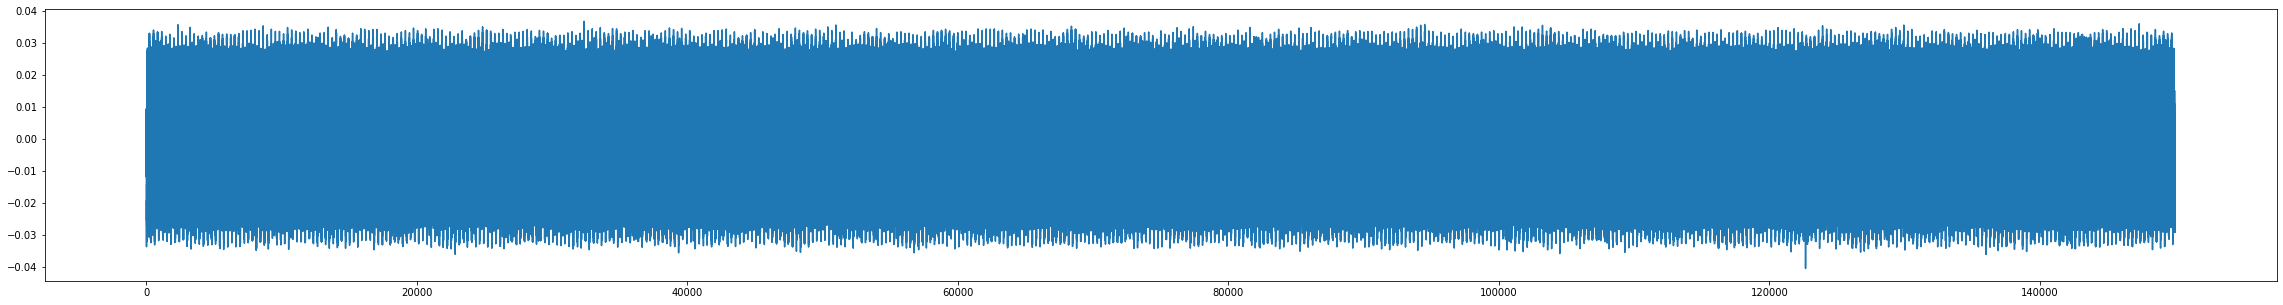

In [ ]:
ndata[ndata["class"]==1]["vibration"].plot(figsize=(40,5))
#visualizing the vibration pattern for fault class 1

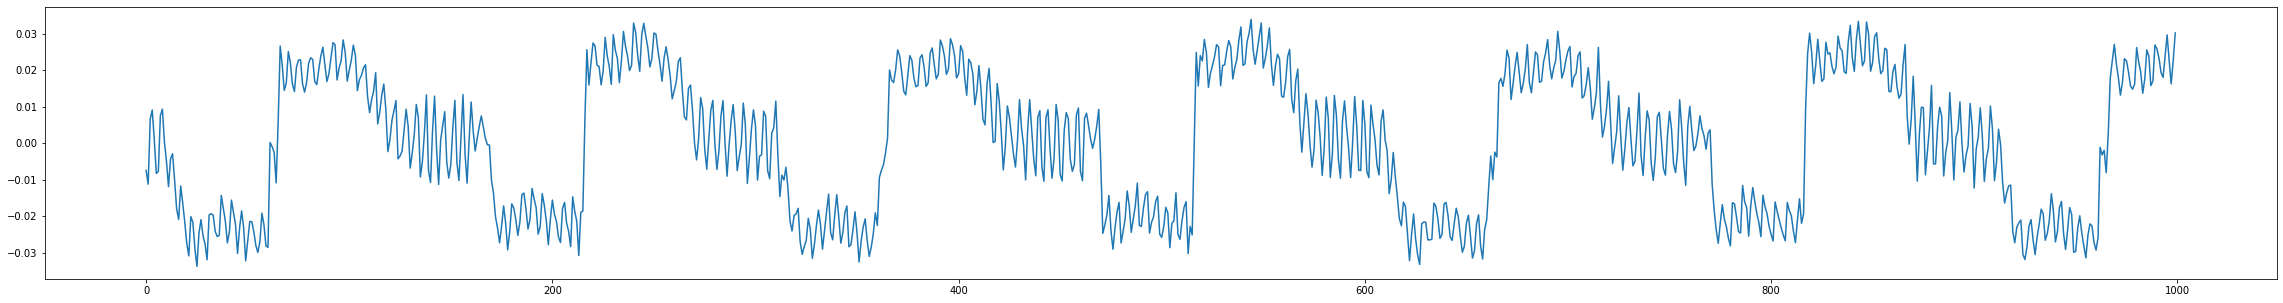

In [ ]:
ndata[ndata["class"]==1]["vibration"].iloc[:1000].plot(figsize=(40,5))
#the first one thousand data points of the vibration among the 150000

In [ ]:

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=4500 #window length of 4500 at one instant
stride=60    
x=[]
y=[]

for i in ndata["class"].unique():      #loop over each class
  def_temp_2=ndata[ndata["class"]==i]   #take all the rows that belongs to one class
  
  for i in np.arange(0, len(def_temp_2) - (win_len), stride):  #create a list containing all the starting points to take one window length data at a time
    temp = def_temp_2.iloc[i:i+win_len, :-1].values           #take 4500 data points(window length) for each starting point
    temp = temp.reshape((1, -1))                              #reshape the column vector into row vevtor
    x.append(temp)                                            # append it to the list x
    y.append(def_temp_2.iloc[i+win_len, -1])                   #append the corresponding class label of the 4500 data points
x=np.array(x)                                                 #convert the list to an array
#x=x.reshape((x.shape[0], -1, 1))                              #reshape x in such a way it we can input it to CNN
x=x.reshape((x.shape[0],win_len))
y=np.array(y)                                                 
encoder= LabelEncoder()                      #label encoder not neccesary 
encoder.fit(y)
encoded_y=encoder.transform(y)
OHE_y=to_categorical(encoded_y)               #converting the class labels to one hot encoded vectors

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,OHE_y,test_size=0.3,shuffle=True, random_state=2022)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14550 samples in 0.043s...
[t-SNE] Computed neighbors for 14550 samples in 58.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14550
[t-SNE] Computed conditional probabilities for sample 2000 / 14550
[t-SNE] Computed conditional probabilities for sample 3000 / 14550
[t-SNE] Computed conditional probabilities for sample 4000 / 14550
[t-SNE] Computed conditional probabilities for sample 5000 / 14550
[t-SNE] Computed conditional probabilities for sample 6000 / 14550
[t-SNE] Computed conditional probabilities for sample 7000 / 14550
[t-SNE] Computed conditional probabilities for sample 8000 / 14550
[t-SNE] Computed conditional probabilities for sample 9000 / 14550
[t-SNE] Computed conditional probabilities for sample 10000 / 14550
[t-SNE] Computed conditional probabilities for sample 11000 / 14550
[t-SNE] Computed conditional probabilities for sample 12000 / 14550
[t-SNE] Computed conditional probabilities for s

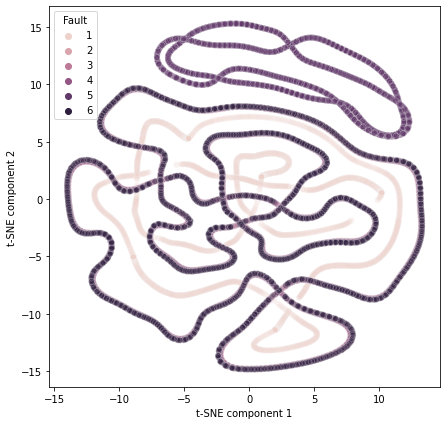

In [ ]:
X_pre_aen = x

from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_aen)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=y


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import concatenate



no_classes = len(ndata['class'].unique())
#head 1
inputs1 = Input(shape=(x.shape[1],x.shape[2]))
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)
# head 2
inputs2 = Input(shape=(x.shape[1],x.shape[2]))
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)
# head 3
inputs3 = Input(shape=(x.shape[1],x.shape[2]))
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = concatenate([flat1, flat2, flat3])          #merging the three paraller convolutional layers
# interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

# Plot Model
cnn_model.summary()
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4500, 1)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4500, 1)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4500, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4301, 64)     12864       ['input_1[0][0]']                
                                                                                              

In [ ]:
batch_size =100
epochs = 3
history = cnn_model.fit([x_train,x_train,x_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([x_test,x_test,x_test],y_test),shuffle=True)

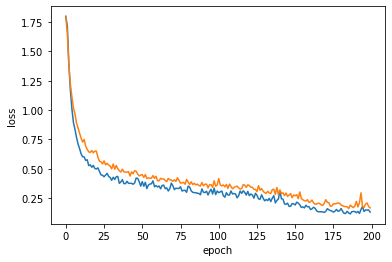

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")

plt.savefig("/content/drive/MyDrive/new folder/loss1.png", dpi=300)

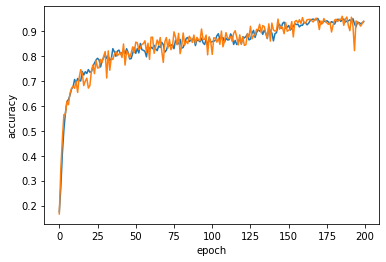

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.savefig("/content/drive/MyDrive/new folder/accura1.png", dpi=300)

TESTING THE MULTIPLE KERNEL METHOD on second round data

*   List item
*   List item





In [ ]:
ndata=pd.read_csv("/content/drive/MyDrive/new folder/second round/normal/cw/1500/backup_02.csv")
ndata["vibration"]=(ndata["Voltage_0"]/0.1)
ndata=pd.DataFrame(ndata["vibration"])
ndata["class"]=1


In [ ]:

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=4500 #window length of 1000 at one instant
stride=200
x=[]
y=[]

for i in ndata["class"].unique():
  def_temp_2=ndata[ndata["class"]==i]
  
  for i in np.arange(0, len(def_temp_2) - (win_len), stride):
    temp = def_temp_2.iloc[i:i+win_len, :-1].values
    temp = temp.reshape((1, -1))
    x.append(temp)
    y.append(def_temp_2.iloc[i+win_len, -1])
x=np.array(x)
#x=x.reshape((x.shape[0], win_len))
#x=x.reshape((x.shape[0], 32, 32,1))          #cnn_image
x=x.reshape((x.shape[0], -1, 1))

y=np.array(y)
encoder= LabelEncoder()
encoder.fit(y)
encoded_y=encoder.transform(y)
OHE_y=to_categorical(encoded_y)

In [ ]:
x.shape

(2425, 4500, 1)

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/modelprejects/trained model.h5")



In [ ]:
prediction=cnn_model.predict([x,x,x])
prediction

In [ ]:
(1/len(prediction))*np.sum(prediction, axis=0)      

array([8.3729869e-16, 5.1166854e-08, 9.9148858e-01, 8.2880454e-03,
       1.5710770e-09, 2.2324479e-04], dtype=float32)